In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import healpy as hp
from rubin_scheduler.scheduler.utils import CurrentAreaMap, Footprint, make_rolling_footprints
from rubin_scheduler.utils import DEFAULT_NSIDE, SURVEY_START_MJD
from rubin_scheduler.site_models import Almanac
import sqlite3
import pandas as pd
from os.path import basename
from rubin_sim.data import get_baseline

import rubin_sim.maf_proto as maf


In [2]:
baseline_file = get_baseline()
run_name = basename(baseline_file).replace('.db', '')
con = sqlite3.connect(baseline_file)
# Dataframe is handy for some calcs
df = pd.read_sql("select * from observations where night < 1200;", con)
# But mostly want numpy array for speed.
baseline_array = df.to_records(index=False)
con.close()


In [3]:
baseline_file = 'all_early_v4.3.2_10yrs.db'
run_name = basename(baseline_file).replace('.db', '')
con = sqlite3.connect(baseline_file)
# Dataframe is handy for some calcs
df = pd.read_sql("select * from observations where night < 1200;", con)
# But mostly want numpy array for speed.
ge_array = df.to_records(index=False)
con.close()


In [4]:
class night_at_three():
    def __call__(self, data_slice, slice_point=None):
        data_slice.sort(order="night")
        if np.size(data_slice) < 3:
            return np.nan
        else:
            return data_slice["night"][2]

In [5]:
nside = 64
sl = maf.Slicer(nside=nside)


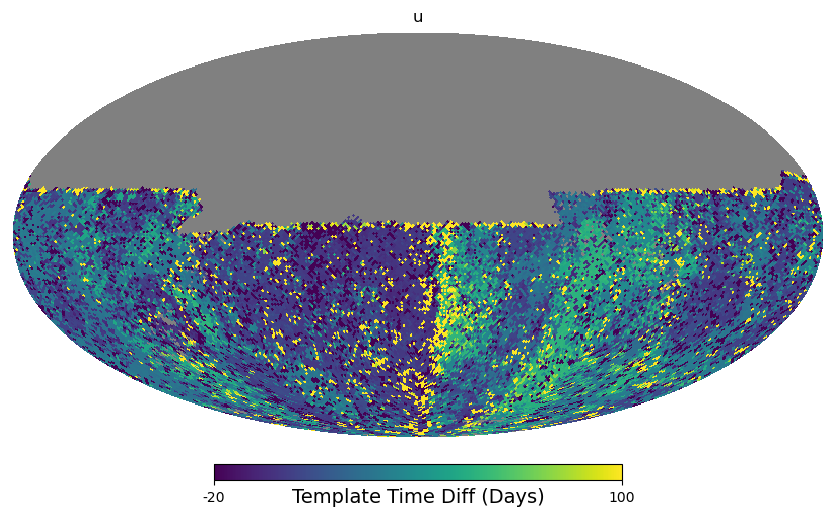

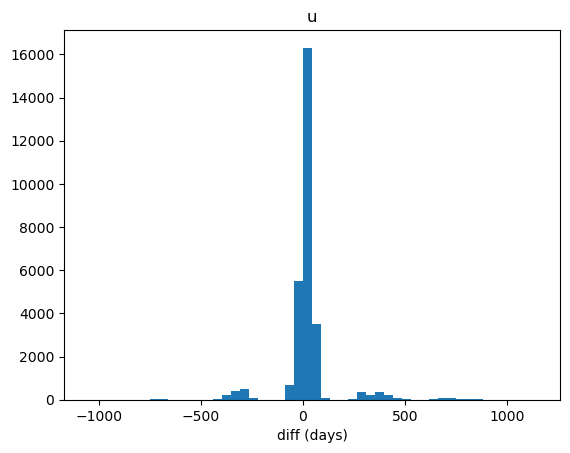

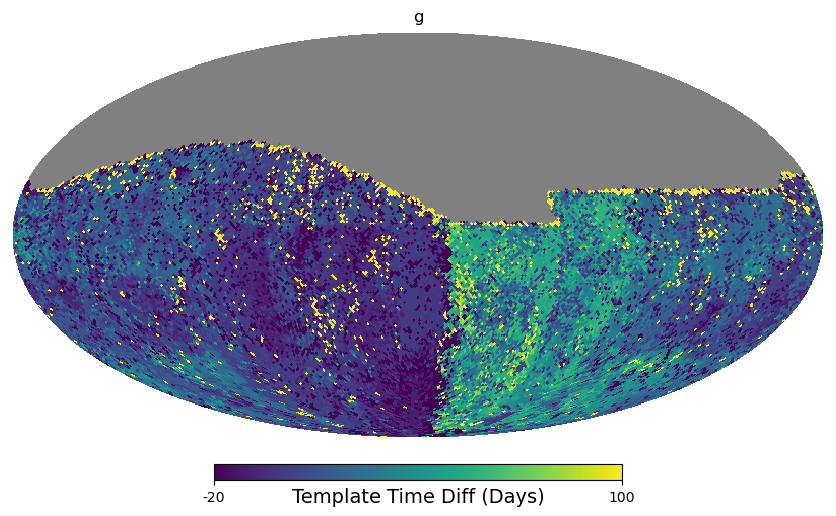

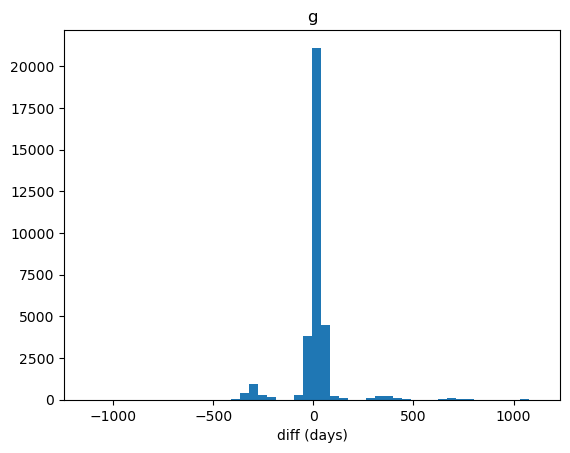

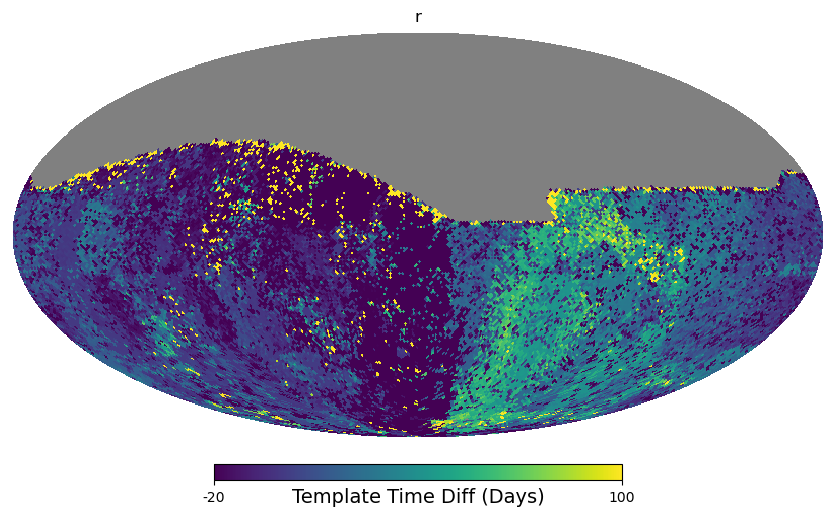

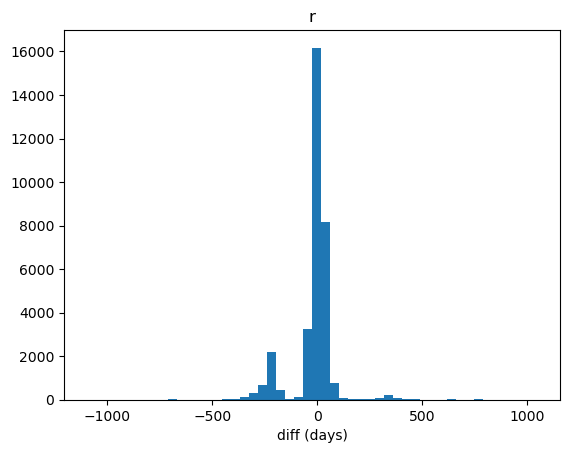

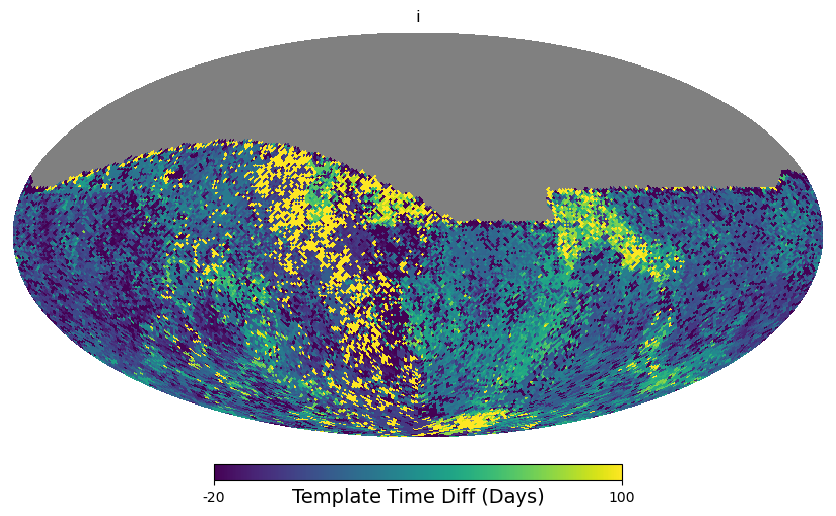

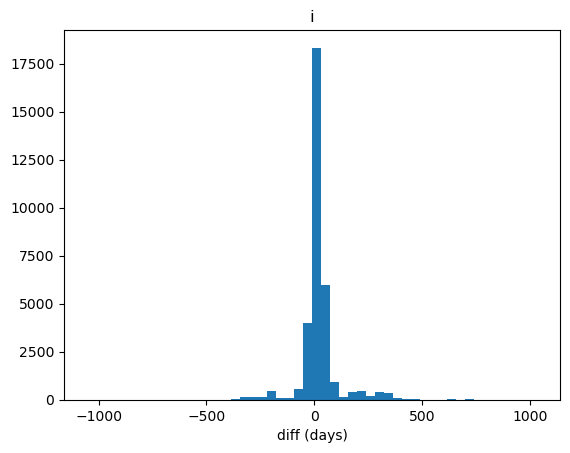

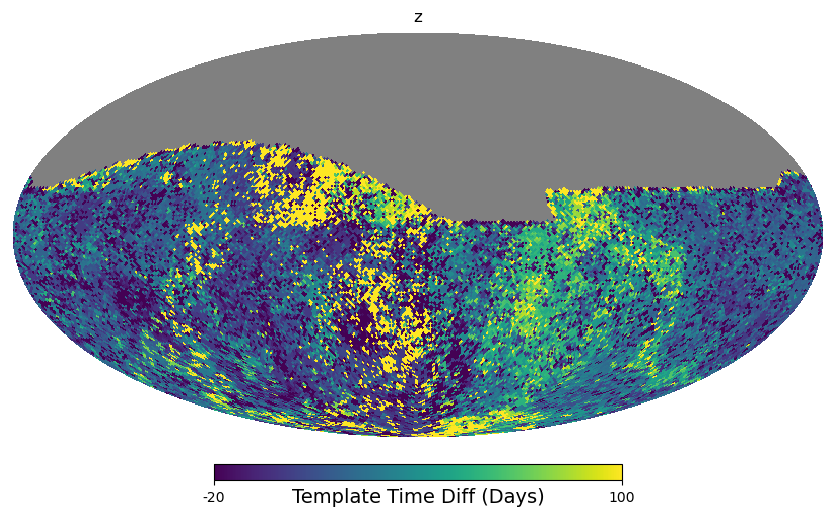

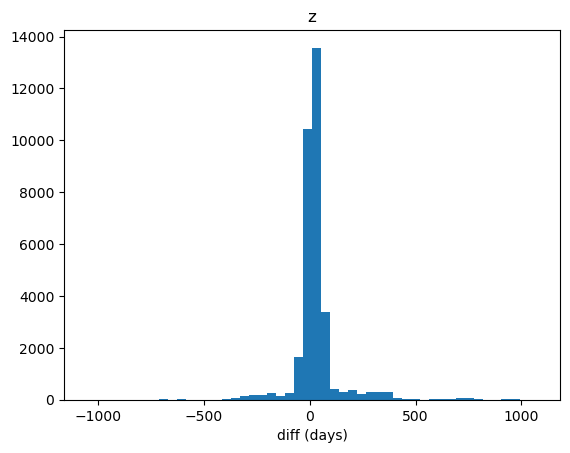

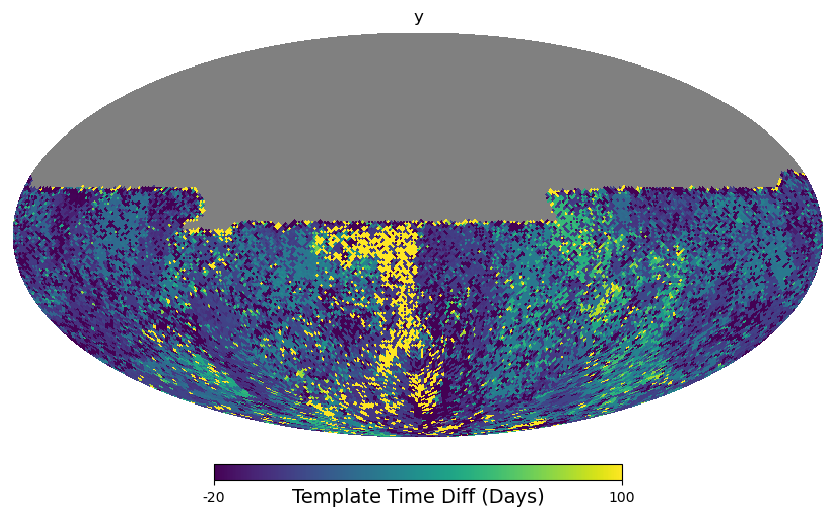

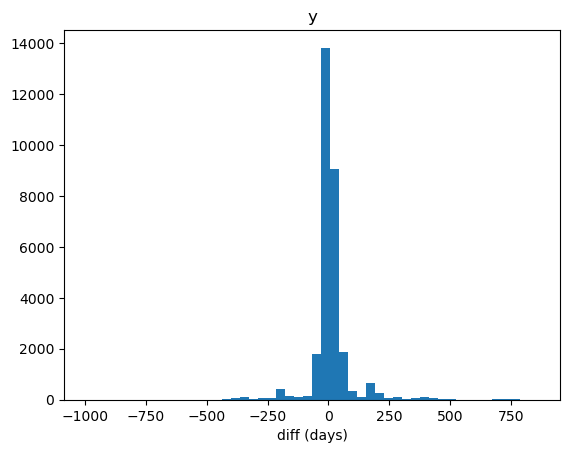

In [6]:
medians = {}
for filtername in 'ugrizy':

    sub_indx_baseline = np.where((baseline_array["filter"] == filtername) & (baseline_array["visitExposureTime"] > 22.))[0]
    sub_indx_ge = np.where((ge_array["filter"] == filtername) & (ge_array["visitExposureTime"] > 22.))[0]
    baseline_hp_array = sl(baseline_array[sub_indx_baseline], night_at_three())
    ge_hp_array = sl(ge_array[sub_indx_ge], night_at_three())
    
    diff = baseline_hp_array - ge_hp_array
    medians[filtername] = np.nanmedian(diff)
    
    hp.mollview(diff, min=-20, max=100, unit="Template Time Diff (Days)", title=filtername)

    fig, ax = plt.subplots()
    ax.hist(diff, bins=50)
    ax.set_title(filtername)
    ax.set_xlabel("diff (days)")



In [7]:
# Median differences. Positive means templates were possible earlier, neagative means later
pd.DataFrame([medians])

,u,g,r,i,z,y
0,22.0,8.0,0.0,16.0,18.0,4.0


In [8]:
medians

{'u': np.float64(22.0),
 'g': np.float64(8.0),
 'r': np.float64(0.0),
 'i': np.float64(16.0),
 'z': np.float64(18.0),
 'y': np.float64(4.0)}